# **Backpropagation from Scratch**

In [132]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [133]:
from graphviz import Digraph
# https://stackoverflow.com/questions/46182603/graphviz-not-running-in-jupyter-notebook-python-3-6

## Derivation is at the heart of backpropagation
Derivation helps us undrstand how a function behaves if the input is modified.Given a function f(x), how does the function behave if input x is modified with h i.e x+h.

In case of backpropagation, the inputs are weights and biases. We want to understand what happens if small changes(h) are made to x(weights and biases)

### Now lets take a simple equation f(x) to understand how the function behaviour changes upon increasing it with a small value

In [134]:
def f(x):
  # return 3*x**2 - 4*x + 5
  return 4*x**2 - 5*x + 6

In [135]:
f(3.0)

27.0

In [136]:
xs = np.arange(-5, 5, 0.5)
ys = f(xs)
ys

array([131. , 109.5,  90. ,  72.5,  57. ,  43.5,  32. ,  22.5,  15. ,
         9.5,   6. ,   4.5,   5. ,   7.5,  12. ,  18.5,  27. ,  37.5,
        50. ,  64.5])

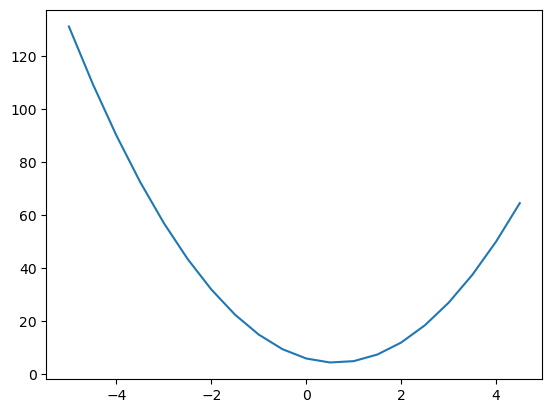

In [137]:
plt.plot(xs, ys)

In [138]:
x = 3.0

# to get a more accurate slope, coverge h towards 0
h = 0.00001
f(x+h)

27.000190000399996

Now lets get the slope(f(x+h)-f(x))/h

In [139]:
(f(x+h)-f(x))/h

19.000039999639284

### one more example, a bit more complex

In [140]:
a = 2.0
b = -3.0
c = 10.0

# equation
d = a*b + c

print(d)

4.0


In [141]:
# observe the values when a is increased

def f1(a, b, c):
  return a*b + c

h = 0.00001

a = 2.0
b = -3.0
c = 10.0

d1 = f1(a, b, c)
d2 = f1(a+h, b, c)

# slope when a is increased by h
print("slope when a is increased: ",(d2-d1)/h)

d2 = f1(a, b+h, c)
# slope when b is increased by h
print("slope when b is increased: ",(d2-d1)/h)

d2 = f1(a, b, c+h)
# slope when c is increased by h
print("slope when c is increased: ",(d2-d1)/h)

slope when a is increased:  -3.000000000064062
slope when b is increased:  2.0000000000131024
slope when c is increased:  0.9999999999621422


### Neural Networks have massive expressions so lets start with creating a data structure to maintain these expressions

In [223]:
class Operand:
    def __init__(self, value, _children = (), _operation='', _label = ''):
        self.value = value
        self.gradient = 0.0
        self._backward = lambda: None
        self._prev_ops = set(_children)
        self._operation = _operation
        self._label = _label
    
    def __repr__(self):
        return f"Variable(value={self.value})"

    # adding two operands
    def __add__(self, other):
        addition = Operand(self.value + other.value, (self, other), '+')

        def _backward():
            self.gradient = 1.0 * addition.gradient
            other.gradient = 1.0 * addition.gradient

        addition._backward = _backward
        return addition

    # subtracting two operands

    # multiplying two operands
    def __mul__(self, other):
        product = Operand(self.value * other.value, (self, other), '*')
        def _backward():
            self.gradient = other.value * product.gradient
            other.gradient = self.value * product.gradient
        
        product._backward = _backward
        return product

    def tanh(self):
        x = self.value
        tanh_x = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        y = Operand(tanh_x, (self, ),'tanh')

        def _backward():
            self.gradient = (1 - tanh_x**2) *  y.gradient

        y._backward = _backward
        return y
        
    # dividing two operands


In [143]:
a = Operand(2.0, _label='a')
b = Operand(-3.0, _label='b')
c = Operand(8.0, _label='c')
d = a*b
d._label = 'd'
e = d + c
e._label='e'
f = Operand(-2.0, _label='f')

#Loss function
L = e * f; L._label='L'
L
# e, e._prev_ops, e._operation

Variable(value=-4.0)

In [144]:
def trace(root):
    nodes = set()
    edges = set()
    def build_graph(node):
        if node not in nodes:
            nodes.add(node)
            for child in node._prev_ops:
                edges.add((child, node))
                build_graph(child)
    build_graph(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for node in nodes:
        nid = str(id(node))
        dot.node(name=nid, label = "{%s | value %.4f | gradient %.4f}" % ( node._label, node.value, node.gradient), shape='record')
        if node._operation:
            dot.node(name=nid + node._operation, label=node._operation)
            dot.edge(nid + node._operation, nid)
    
    for e1, e2 in edges:
        dot.edge(str(id(e1)), str(id(e2)) + e2._operation)
    
    return dot

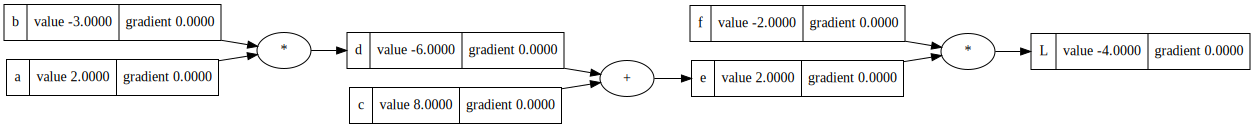

In [145]:
draw_dot(L)

### Lets find gradients 

derivatives of weights w.r.t Loss L

Note: In the above example, a and b is the fixed data i.e the input to the NN, while c, d, e, f are the weights.

**What should be the values of weights so the loss is minimized? Derivativation will help us find that out.**

In [146]:
# derivative of variable w.r.t to itself is 1 so derivative of L w.r.t itself will be 1
L.gradient = 1.0

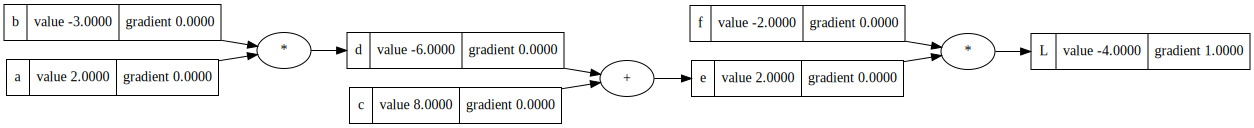

In [147]:
draw_dot(L)

**lets compute dL/de**

for y = f(x), dy/dx = (f(x+h) - f(x))/h

here, L = e*f

so, dL/de = ((e+h) * f - (e) * f)/h
          = (e*f + h*f -e*f)/h
          = (h*f)/h
          = f

therefore, dL/de = f

similarly, dL/df = e

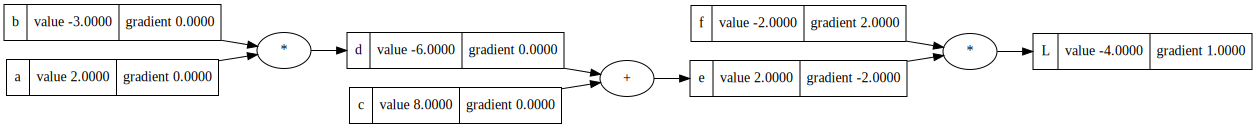

In [148]:
e.gradient = f.value
f.gradient = e.value

draw_dot(L)

**now lets compute dL/dc by using [chain rule](https://en.wikipedia.org/wiki/Chain_rule)**
dL/dc = (dL/de) * (de/dc)

we have already computed dL/de, lets compute de/dc

de/dc = ?

here, e = c + d

so, de/dc = ((c+h) + d) - (c+d)/ h
          = (c + h + d - c -d )/h
          = h/h 
          = 1.0

so dL/dc = (dL/de) * (de/dc)
         = f * 1.0
         = f

similary de/dd = 1.0 and dL/dd = f


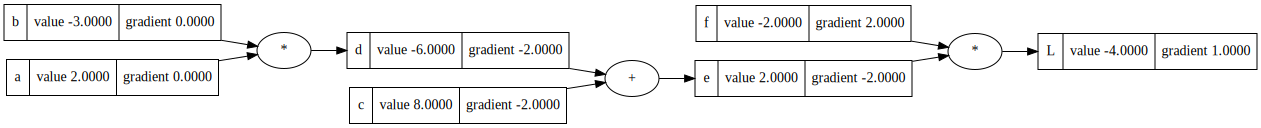

In [149]:
c.gradient = f.value
d.gradient = f.value

draw_dot(L)

dL/da = dL/dd * dd/da

dL/dd = f 

dd/da = ?

d = a * b

so dd/da = (((a + h)* b) - (a * b)) / h = (a*b + h*b - a*b ) /h = (h*b)/h = b

therefore dL/da = f * b

similarly dL/db = f * a


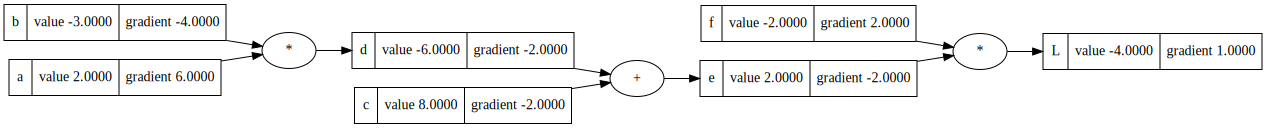

In [150]:
a.gradient = f.value * b.value
b.gradient = f.value * a.value

draw_dot(L)

In [151]:
# function to verify the derivatives values, just change variable by h and solve for the derivative
def solve():
    h = 0.001
    a = Operand(2.0, _label='a')
    b = Operand(-3.0, _label='b')
    c = Operand(8.0, _label='c')
    d = a*b
    d._label = 'd'
    e = d + c
    e._label='e'
    f = Operand(-2.0, _label='f')

    #Loss function
    L = e * f; L._label='L'

    L1 = L.value

    a = Operand(2.0 + h, _label='a')
    b = Operand(-3.0, _label='b')
    c = Operand(8.0, _label='c')
    # c.value += h
    d = a*b
    d._label = 'd'
    e = d + c
    e._label='e'
    f = Operand(-2.0, _label='f')

    #Loss function
    L = e * f; L._label='L'
    L2= L.value

    print((L2 -L1)/h)

In [152]:
solve()

6.000000000000227


one more example to see how we can affect the loss

as we change the operand by a small value, the loss should go up

In [154]:
a.value += 0.01 * a.gradient
b.value += 0.001 * b.gradient
c.value += 0.001 * c.gradient
f.value += 0.001 * f.gradient

d = a*b
e = d + c
L = e * f

L

Variable(value=-3.23160384)

## Neural Networks are made up of layers of neurons

### Backpropagation through a Neuron

Activation function

squashing function

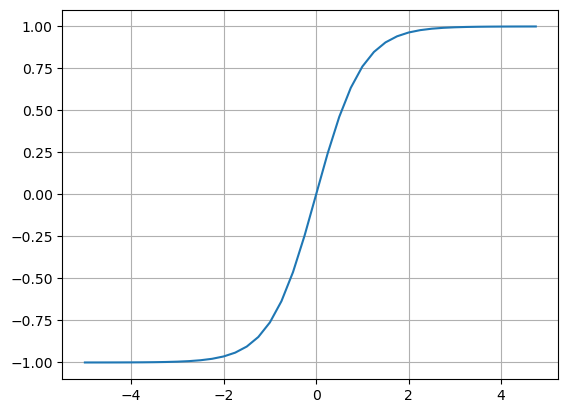

In [156]:
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25)))
plt.grid()

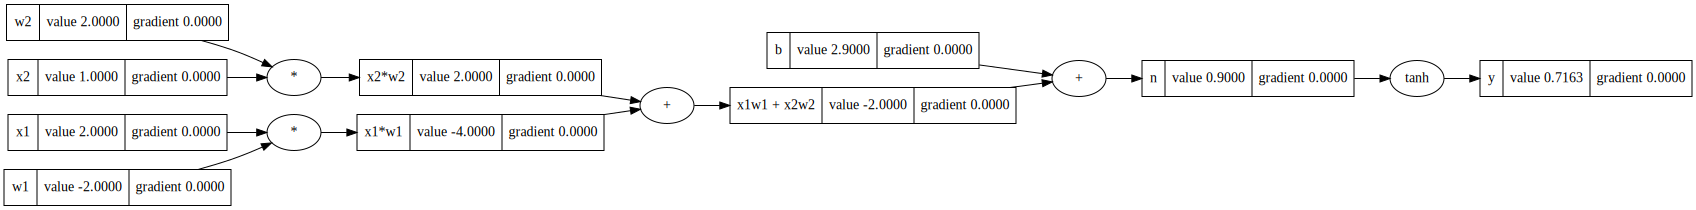

In [235]:
# single neuron

# inputs: x1, x2
x1 = Operand(2.0, _label='x1')
x2 = Operand(1.0, _label='x2')

# weights: w1, w2
w1 = Operand(-2.0, _label='w1')
w2 = Operand(2.0, _label='w2')

# bias
b = Operand(2.9, _label='b')

# loss: x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1._label ='x1*w1'
x2w2 = x2 * w2; x2w2._label = 'x2*w2' 
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n._label = 'n'

y = n.tanh(); y._label='y'
draw_dot(y)

### gradients for the above neuron

start backwards from y

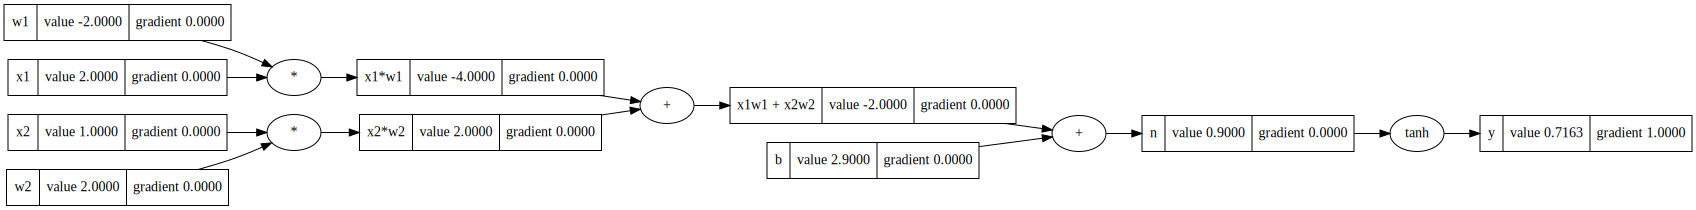

In [216]:
# derivative of y_hat w.r.t is 1
y.gradient = 1.0

draw_dot(y)

dy/dn = ?

here, y = tanh(n) and derivative of tanh = 1 - tanh(n**2)

so dy/dn = 1 - tanh(n**2)
         = 1 - (y**2)

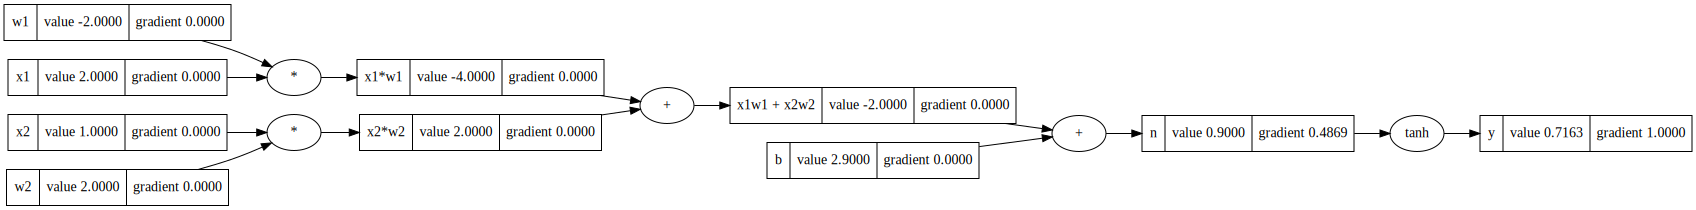

In [217]:
n.gradient =  1 - (y.value ** 2)

draw_dot(y)

dy/db = dy/dn * dn/db
dn/db = ?

here, n = x1 * w1 + x2 * w2 + b

dn/db = ((x1 * w1 + x2 * w2 + (b + h)) - (x1 * w1 + x2 * w2 + b))/h
      = (x1 * w1 + x2 * w2 + b + h - (x1 * w1) - (x2 * w2) - b) /h
      = h/h
      = 1

      
therefore,
dy/db = n.gradient * 1

similarly,

dy/(x1*w1 + x2*w)2 = n.gradient * 1

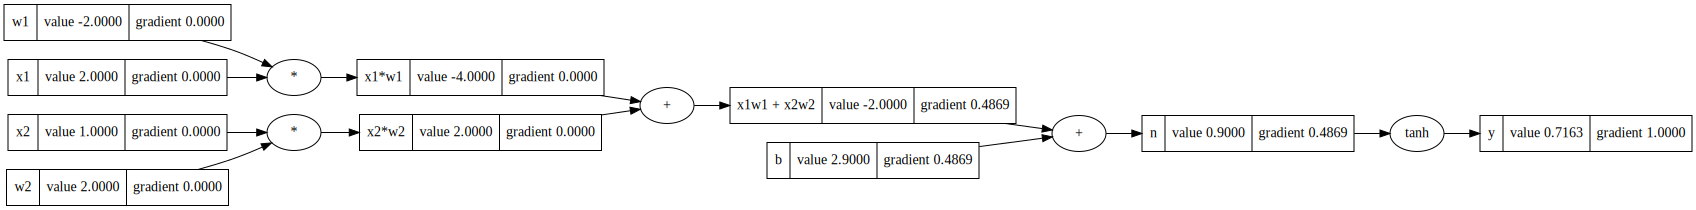

In [218]:
b.gradient = n.gradient * 1
x1w1x2w2.gradient = n.gradient * 1

draw_dot(y)

the derivatives for node x1*w1 and x2*w2 can be computed using chain rule similarly 

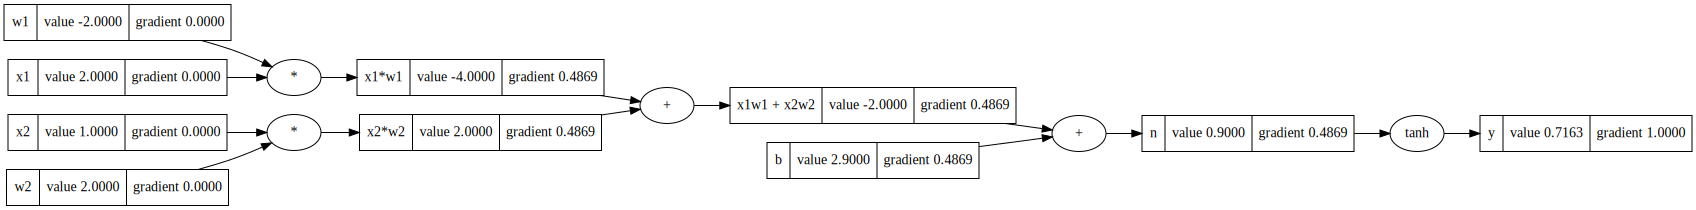

In [219]:
x1w1.gradient = x1w1x2w2.gradient
x2w2.gradient = x1w1x2w2.gradient

draw_dot(y)

the derivatives for x1 and x2 can be computed similarly using chain rule

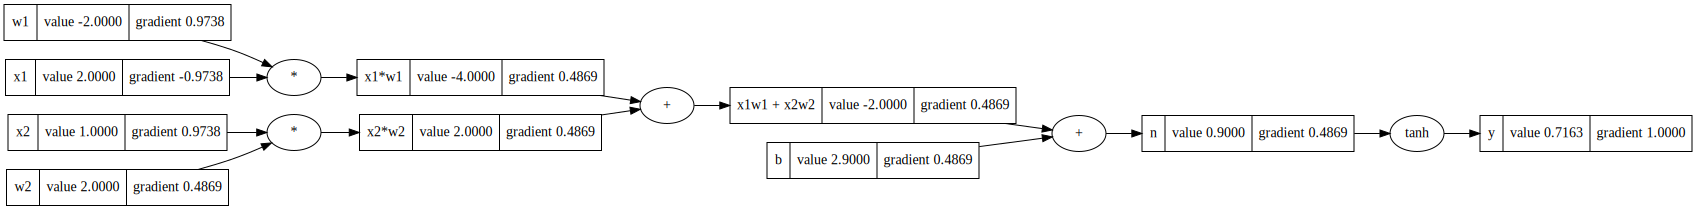

In [220]:
x1.gradient = w1.value * x1w1.gradient
w1.gradient = x1.value * x1w1.gradient

x2.gradient = w2.value * x2w2.gradient
w2.gradient = x2.value * x2w2.gradient


draw_dot(y)

as more neurons are added, the manual calculation of derivatives becomes complex and time consuming so its better to automate by adding a _backward function to the Operand object

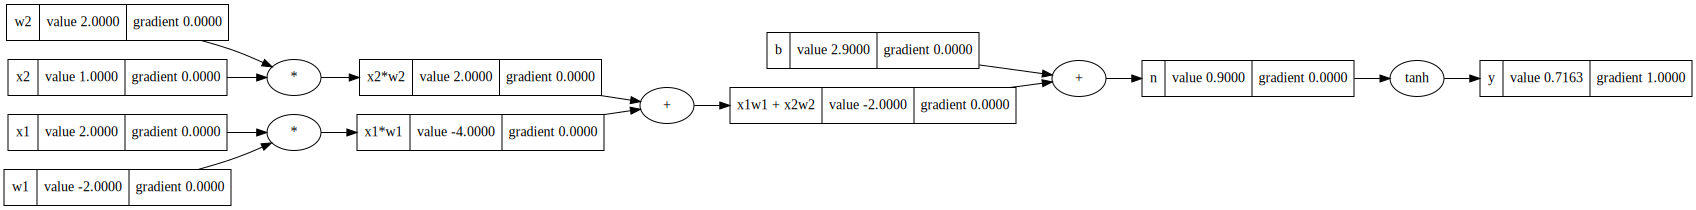

In [236]:
y.gradient = 1.0
draw_dot(y)

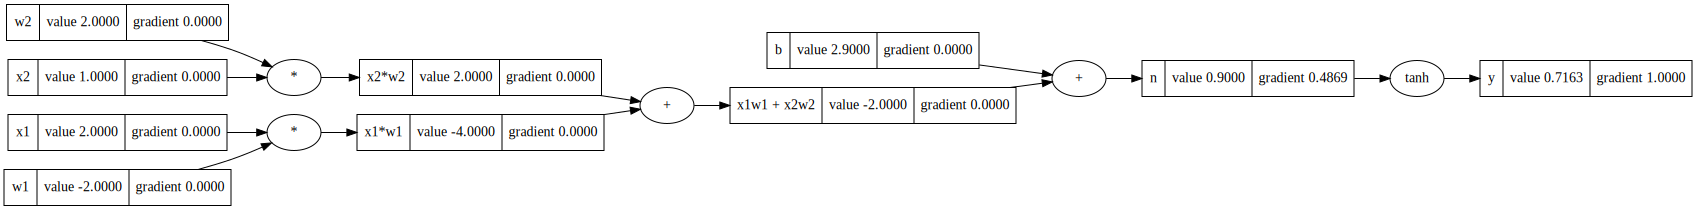

In [237]:
y._backward()
draw_dot(y)

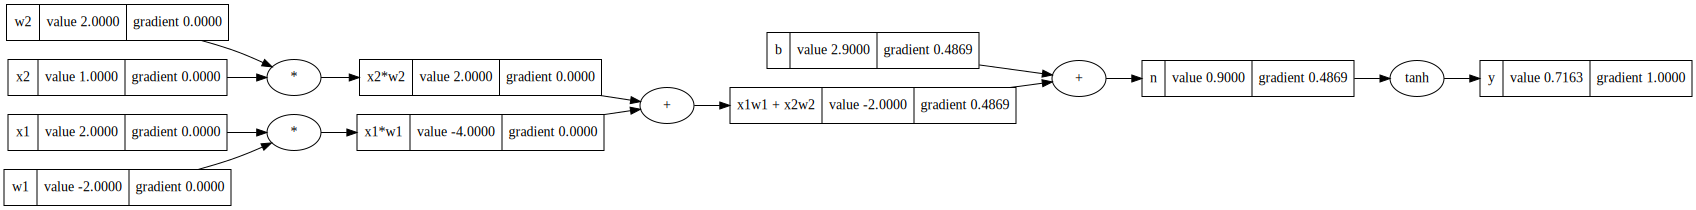

In [238]:
n._backward()
draw_dot(y)

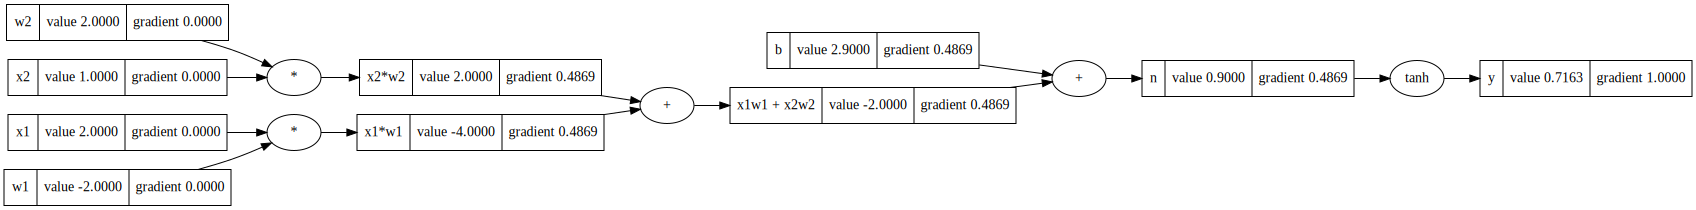

In [239]:
b._backward()
x1w1x2w2._backward()
draw_dot(y)

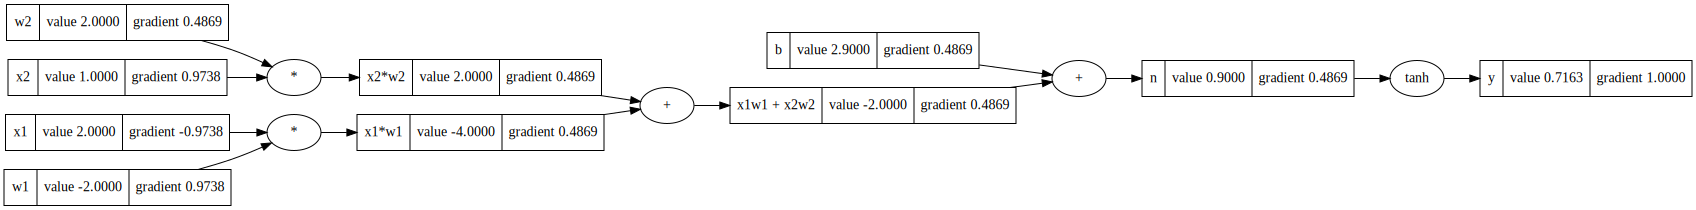

In [240]:
x1w1._backward()
x2w2._backward()
draw_dot(y)

 __Reference: [Neural Networks: Zero to Hero by **Anderj Karpathy**](https://youtu.be/VMj-3S1tku0?si=nt0sYb9Rs2g4qApr)__